
# Time Series Forecasting of Fatality Rate in Motor Vehicle Collision

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date

# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy
# Set font scale and style
plt.rcParams.update({'font.size': 18})

# Stat models
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import custom class
%run -i '../src/helper/ts_analysis.py'

In [3]:
# Instantiate the class
fxn = TimeSeriesAnalysis()

# Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 9)


,fatality_rate,med_fatal,med_injury,med_no_injury,not-head-on,head-on,year,month,summer_ind
date,,,,,,,,,
1999-01-01,0.013067,85.0,99.0,48.0,108.0,124.0,1999,1,0
1999-02-01,0.017570,101.0,108.0,40.0,93.0,156.0,1999,2,0
1999-03-01,0.021727,105.0,170.0,48.0,96.0,227.0,1999,3,0
1999-04-01,0.013606,99.0,84.0,32.0,44.0,171.0,1999,4,0
1999-05-01,0.018343,150.0,165.0,53.0,79.0,289.0,1999,5,0


#  Create a Test  Set
As we saw above, we used the entire observation of the data set to identify the model. However, we would like to show how to use the model to make short-term forecasts. Therefore, we must split the data set into training and test set; we have chosen the test set as the last three year's observations (i.e. 2013-2016).


In [5]:
y = ts['fatality_rate']
N = len(y)

exog_variables = list(ts.drop('fatality_rate', axis=1).columns)
X_exog = ts[exog_variables]
X_exog['yearly_seasonality'] = np.arange(N) % 365
X_exog['monthly_seasonality'] = np.arange(N) % 30
# X_exog['weekly_seasonality'] = np.arange(N) % 7

In [6]:
train_start, train_end = '1999-01-01','2016-12-01'
test_start, test_end = '2017-01-01', '2017-12-01'

X_train = X_exog[train_start: train_end]
y_train = y[train_start: train_end]

X_test = X_exog[test_start: test_end]
y_test = y[test_start: test_end]

# Normalisation

In [7]:
# Standardization
scaler_y = StandardScaler() 
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)) 

# Normalization 
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# pandas dataframe
X_train_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns = X_test.columns)

# SARIMAX Model
We build Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors (SARIMAX) model using pmdarima‘s auto_arima(). We set seasonal = True, the frequency m = 12 for monthly time series, and seasonal differencing D = 1.

In [8]:
# Train sarimax from auto arima API
sarimax = pm.auto_arima(y_train_scaled, exogenous = X_train_df, max_p = 4, max_q = 4, D = 1, 
                 m=12, test = 'adf', stepwise=True, suppress_warnings=True, error_action='ignore',                  seasonal= True, random_state= 42, trace = True, n_fits= 20)
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=187.993, Time=0.49 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=549.833, Time=3.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=228.366, Time=3.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1067.942, Time=0.39 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=527943.942, Time=5.85 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=224.194, Time=1.96 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=155958.377, Time=2.74 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=637072.246, Time=1.48 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=40088.782, Time=1.79 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=3253858.335, Time=2.36 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 32.426 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  216
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                 -81.996
Date:                  Wed, 12 May 2021   AIC                            187.993
Time:                          16:06:40   BIC                            227.810
Sample:                               0   HQIC                           204.100
                                  - 216                                         
Covariance Type:                    opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept            7.529e-05      0.027      0.003      0.998      -0.053       0.054
med_fatal            4.935e+08      0.279   1.77e+09      0.000    4.93e+08    4.93e+08
med_injury           7.297e+08      0.233   3.13e+09      0.000     7.3e+08     7.3e+08
med_no_injury        2.811e+08      0.163   1.72e+09      0.000    2.81e+08    2.81e+08
not-head-on         -5.024e+08      0.137  -3.67e+09      0.000   -5.02e+08   -5.02e+08
head-on             -1.229e+09      0.112   -1.1e+10      0.000   -1.23e+09   -1.23e+09
year                -5.976e+12      0.002  -3.73e+15      0.000   -5.98e+12   -5.98e+12
month                  -0.0178   3.13e-18  -5.69e+15      0.000      -0.018      -0.018
summer_ind              0.0010    1.7e-18   5.68e+14      0.000       0.001       0.001
yearly_seasonality   6.298e+12      0.002   4.14e+15      0.000     6.3e+12     6.3e+12
monthly_seasonality    -0.0799      0.056     -1.439      0.150      -0.189       0.029
sigma2                  0.1308      0.013     10.350      0.000       0.106       0.156
===================================================================================
Ljung-Box (L1) (Q):                  29.44   Jarque-Bera (JB):                 4.02
Prob(Q):                              0.00   Prob(JB):                         0.13
Heteroskedasticity (H):               0.90   Skew:                            -0.26
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.57e+35. Standard errors may be unstable.
"""

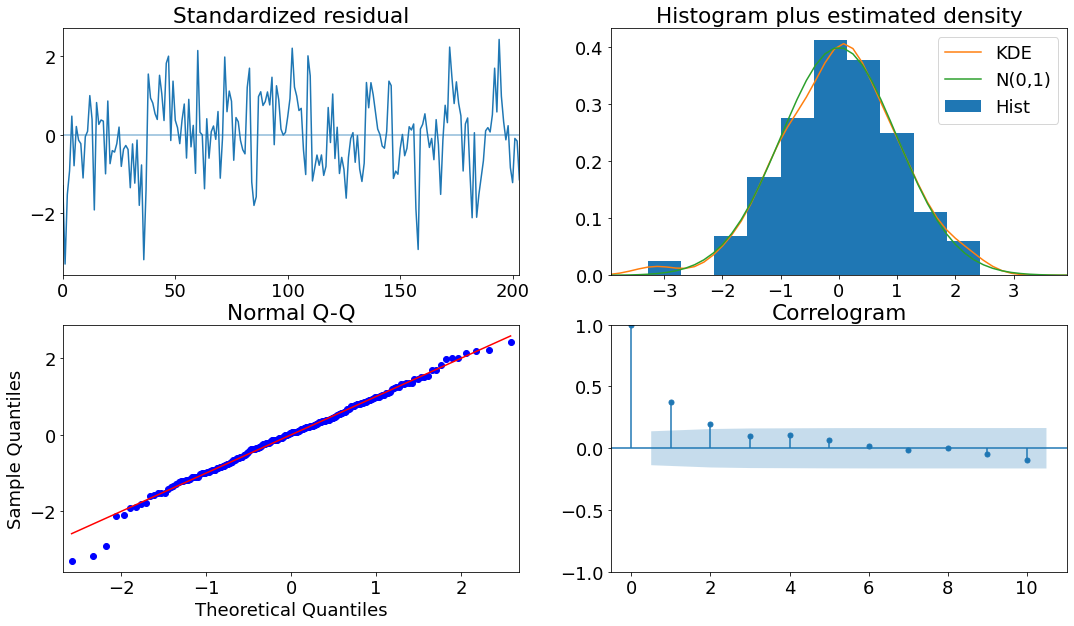

In [9]:
sarimax.plot_diagnostics(figsize=(18,10))
plt.show()

# Test prediction

In [10]:
y_pred, conf_int = sarimax.predict(n_periods = len(y_test), exogenous = X_test_df, return_conf_int=True)

# Inverse transform scale
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1)).flatten()

In [11]:
# y_pred[y_pred<0] = 0
y_low = conf_int[:,0]
y_low = scaler_y.inverse_transform(y_low.reshape(-1,1)).flatten()
y_high = conf_int[:,1]
y_high = scaler_y.inverse_transform(y_high.reshape(-1,1)).flatten()

results = pd.DataFrame()
results['y_pred'] = y_pred
results['y_low'] = y_low
results['y_high'] = y_high
results.index = y_test.index

# Performance measures

In [16]:
mape = fxn.mape(y_test, y_pred)
r2 = fxn.r_squared(y_test, y_pred)
mae = fxn.mae(y_test, y_pred)
rmse = fxn.rmse(y_test, y_pred)

print('MAPE = {}'.format(round(mape,3)))
print('MAE = {}'.format(round(mae,3)))
print('RMSE = {}'.format(round(rmse,3)))
print('R^2 = {}'.format(round(r2,3)))

MAPE = 5.933
MAE = 0.001
RMSE = 0.001
R^2 = 0.909


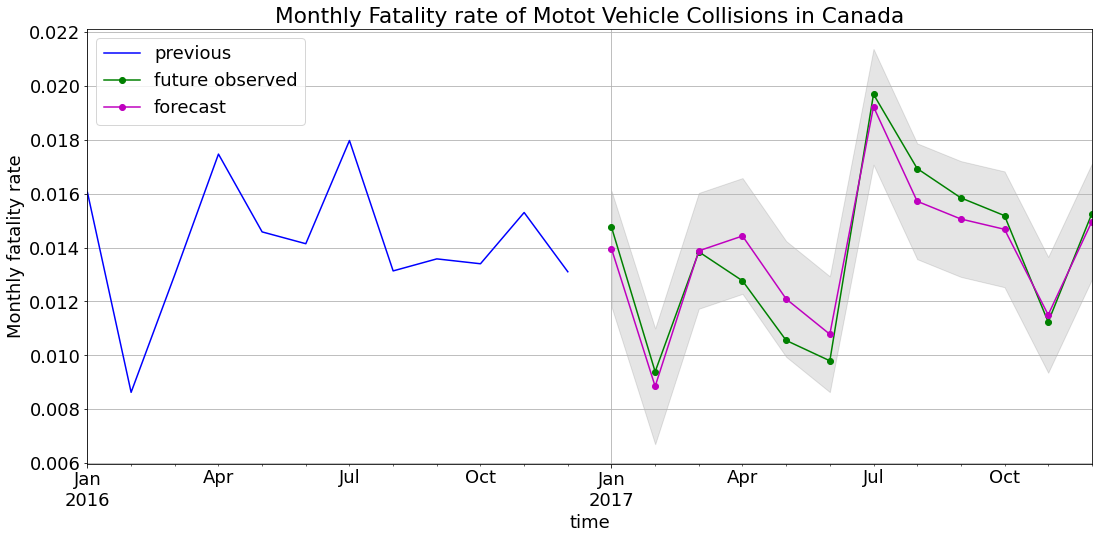

In [17]:
plt.figure(figsize = (18,8))

y_train.iloc[-len(y_test):].plot(label = 'previous', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['y_pred'].plot(label = 'forecast', marker = 'o', color = 'm')

plt.fill_between(results.index, results['y_low'], results['y_high'], color='k', alpha=0.1)
plt.xlabel('time')
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly Fatality rate of Motot Vehicle Collisions in Canada')
plt.legend()
plt.savefig('../images/fig1.png')
plt.show()

# Test set error

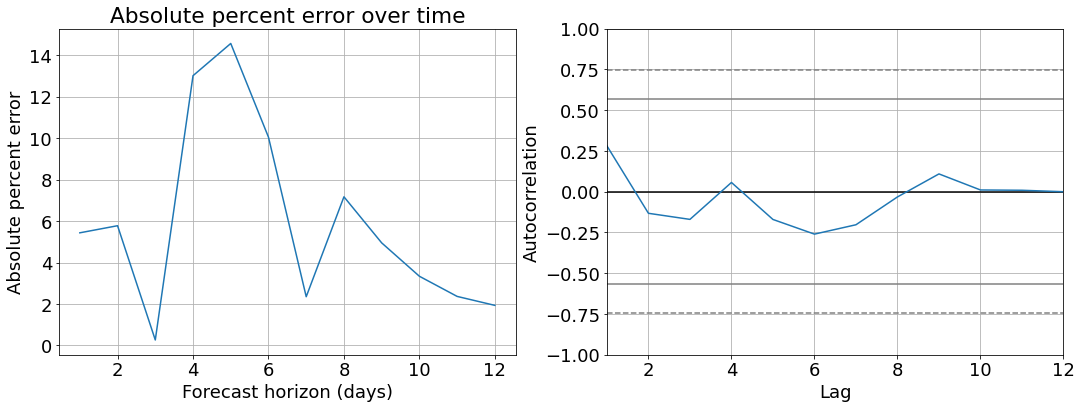

In [14]:
plt.figure(figsize = (18,6))
abs_err = 100*np.abs((y_pred - y_test.values)/(y_test.values))

plt.subplot(121)
plt.plot(np.arange(1, len(abs_err)+1), abs_err)
plt.grid(True)
plt.xlabel('Forecast horizon (days)')
plt.ylabel('Absolute percent error')
plt.title('Absolute percent error over time')

plt.subplot(122)
pm.autocorr_plot(abs_err)
plt.show()

In [15]:
# plt.figure(figsize = (8,6))
# abs_err = 100*np.abs((y_pred - y_test.values)/(y_test.values))

# plt.plot(acorr_ljungbox(abs_err, lags = 11)[0], 'o')
# plt.axhline(y=0.05,linestyle= '--', color = 'k')
# plt.ylabel('p-value', fontsize = 20)
# plt.xlabel('Lag', fontsize = 20)
# plt.title('p-values for Ljung-Box statistic', fontsize = 20)